Adapted from https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

In [1]:
# installed in virtualenv
#%pip install -Uqq duckduckgo_search
#%pip install -Uqq fastai

# activate the Python virtual env, run this in a bash terminal
#source ~/.virtualenvs/fast_ai/Scripts/activate

from fastcore.all import *
from duckduckgo_search import DDGS


In [2]:
# get a bird image
image_url = DDGS().images("bird", max_results=1)[0]["image"]
print(image_url)

http://www.ecstasycoffee.com/wp-content/uploads/2014/12/Lilac-breasted-roller-bird.jpg


c:\Users\Alex\.virtualenvs\fast_ai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


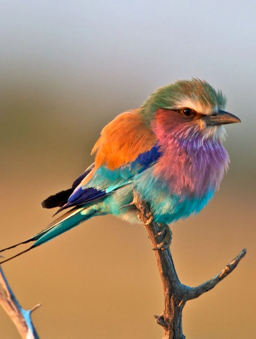

In [3]:
from fastdownload import download_url

dest="bird.jpg"
download_url(image_url, dest, show_progress=False)

from fastai.vision.all import *
image=Image.open(dest)
image.to_thumb(356, 256)

Define a _search_images_ function

"DDGS" is DuckDuckGoSearch  
"L" is a function in fastcore that creates a more efficient _list_ and provides many functionalities.

In [20]:
# to test RateLimitException
#a = DDGS().images("dog", max_results=2)

def search_images(term, max_images=10):
    print(f'Searcing for "{term}" images')
    results = DDGS().images(term, max_results=max_images)
    return L(results).itemgot("image")

Searcing for "dog" images


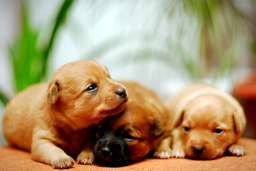

In [21]:
download_url(search_images("dog", max_images=1)[0], "dog.jpg", show_progress=False)
Image.open("dog.jpg").to_thumb(256, 256)


In [23]:
searches = "dog", "cat"
path = Path("images")

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(o, max_images=30))
    sleep(30)
    download_images(dest, urls=search_images(f"{o} on the beach", max_images=20))
    sleep(30)
    #download_images(dest, urls=search_images(f"{o} in the sun", max_images=20))
    #sleep(30)
    download_images(dest, urls=search_images(f"{o} on the sofa", max_images=20))
    sleep(30)
    download_images(dest, urls=search_images(f"{o} on the carpet", max_images=20))

Searcing for "dog" images


RatelimitException: https://duckduckgo.com/ 202 Ratelimit

In [24]:
# some could possibly not download correctly, we remove them

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"removed {len(failed)} images")

removed 11 images


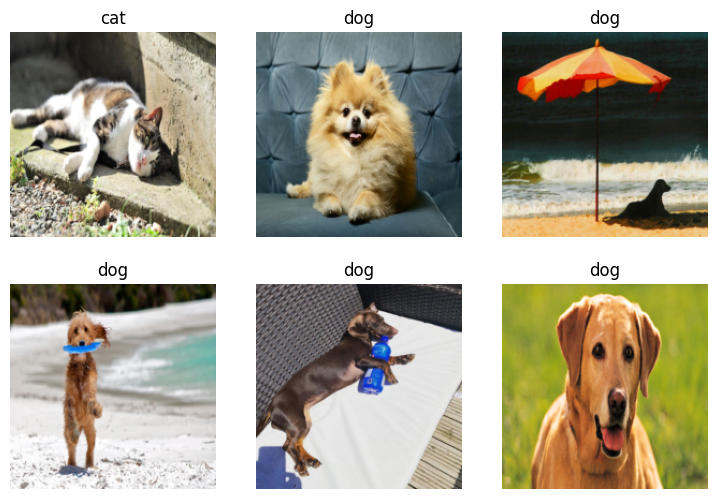

In [25]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # a random 20% of images are used for training
    get_y=parent_label, # get the label from parent folder inpath ("cat", "dog") and use it to create the result categories
    item_tfms=[Resize(192, method="squish")]  # to have the same dimensions  (192x192)
).dataloaders(path)

# dataloader will FEED the algorithm with batches of data

dls.show_batch(max_n=6)  ## see an example of input provided to the AI

DataBlock is container to create DataSet and DataLoaders.  

There are many Blocks: https://docs.fast.ai/data.block.html

https://docs.fast.ai/


In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)  # use resnet18 model
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.945097,0.145051,0.052083,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.215940,0.059946,0.041667,01:22
1,0.142324,0.035628,0.020833,01:21
2,0.098925,0.054128,0.020833,01:22
3,0.072570,0.059504,0.020833,01:21


Models are pre-trained models.  
Orther models can be found here: https://timm.fast.ai  

_fine_tune_ will adapt the model (that is trained with its images) to our dataset.



In [28]:
xlearn = vision_learner(dls, xresnet50, metrics=error_rate)  # use xresnet50 model
xlearn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.093939,2.714283,0.385417,02:21


epoch,train_loss,valid_loss,error_rate,time
0,0.412164,0.971142,0.333333,02:55
1,0.342448,0.703185,0.250000,03:02
2,0.285994,0.454636,0.166667,02:57
3,0.248969,0.403220,0.135417,02:57
4,0.223362,0.365195,0.114583,02:55


Searcing for "cat on red sofa in january" images


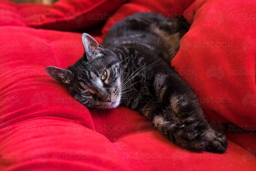

In [29]:
test_image = "test-animal.jpg"
download_url(search_images("cat on red sofa in january", max_images=1)[0], test_image, show_progress=False)
Image.open(test_image).to_thumb(256, 256)


In [30]:
cat_or_dog,_,probs = learn.predict(PILImage.create(test_image))
#print(f'Probability is a dog {probs[0]:.4f}')
print(f'Probability is a cat {probs[0]*100:.2f}%')
print(f'Probability is a dog {probs[1]*100:.2f}%')

print(f"cat_or_dog: {cat_or_dog}")


Probability is a cat 95.80%
Probability is a dog 4.20%
cat_or_dog: cat


In [ ]:
# Save the trained model

